In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import andrews_curves
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf

In [155]:
covid_df=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-states.csv', parse_dates=True)
#https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [156]:
covid_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [157]:
covid_df.drop('fips', axis=1, inplace=True)

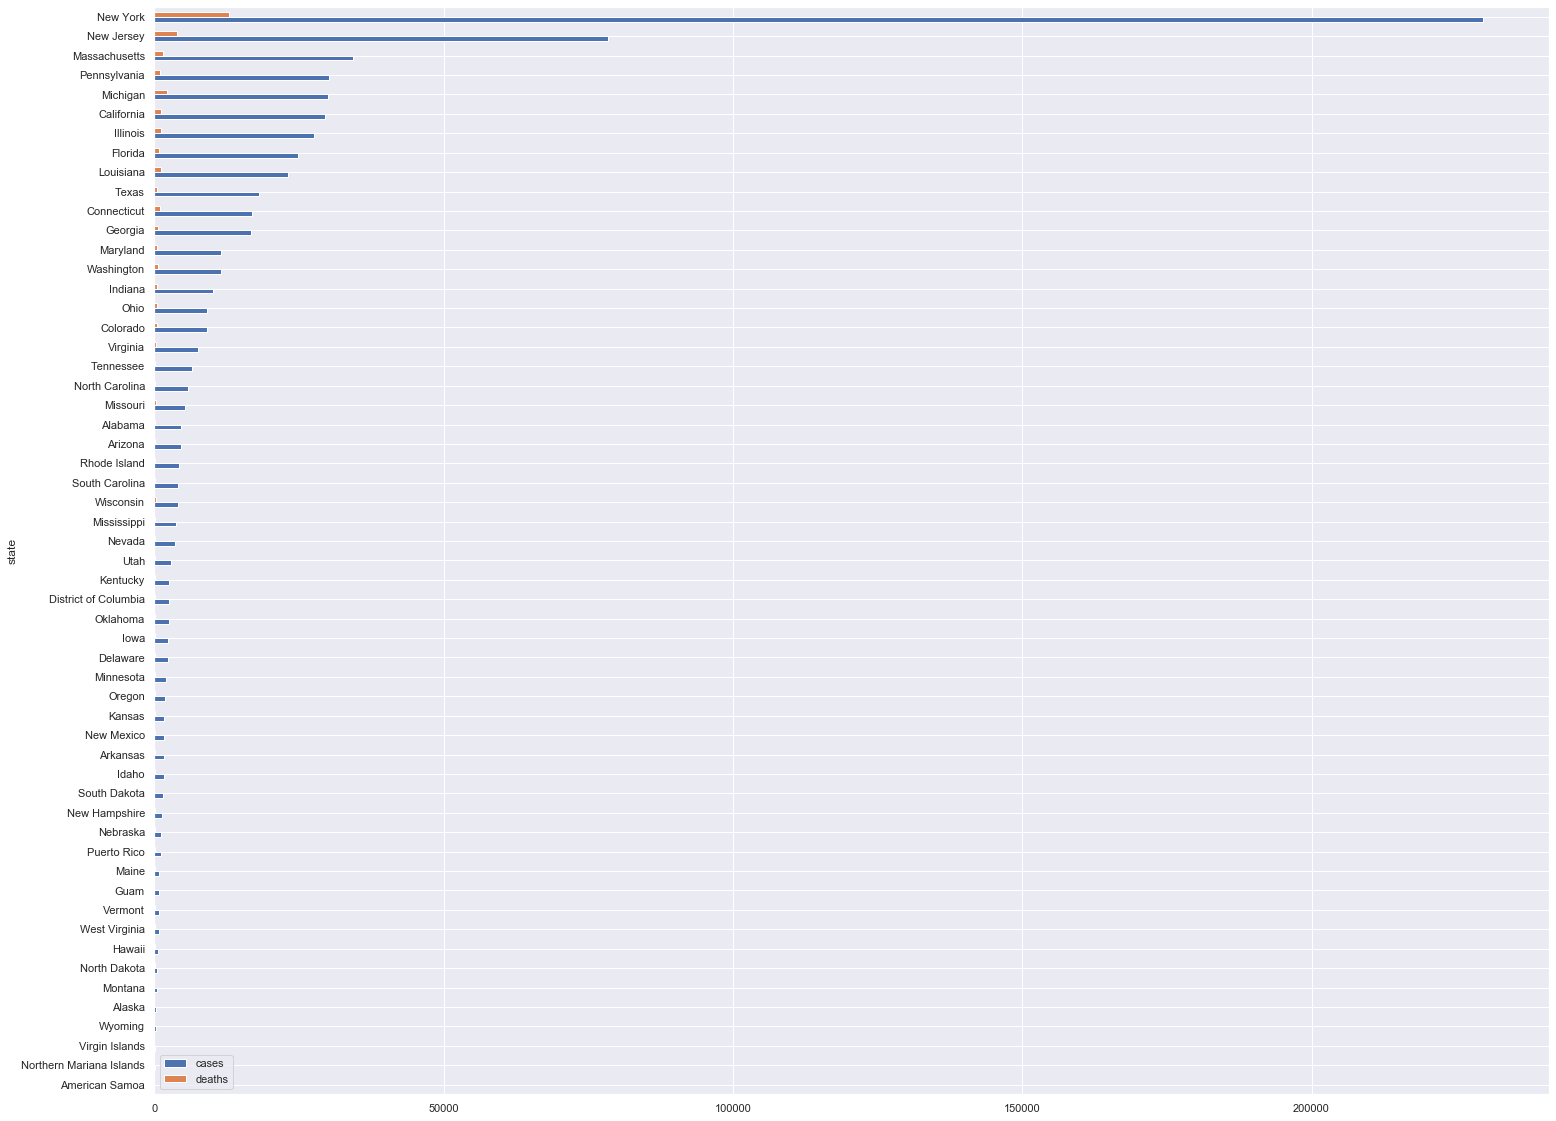

In [158]:
covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=True).plot(kind='barh', figsize=(25,20), grid=True)

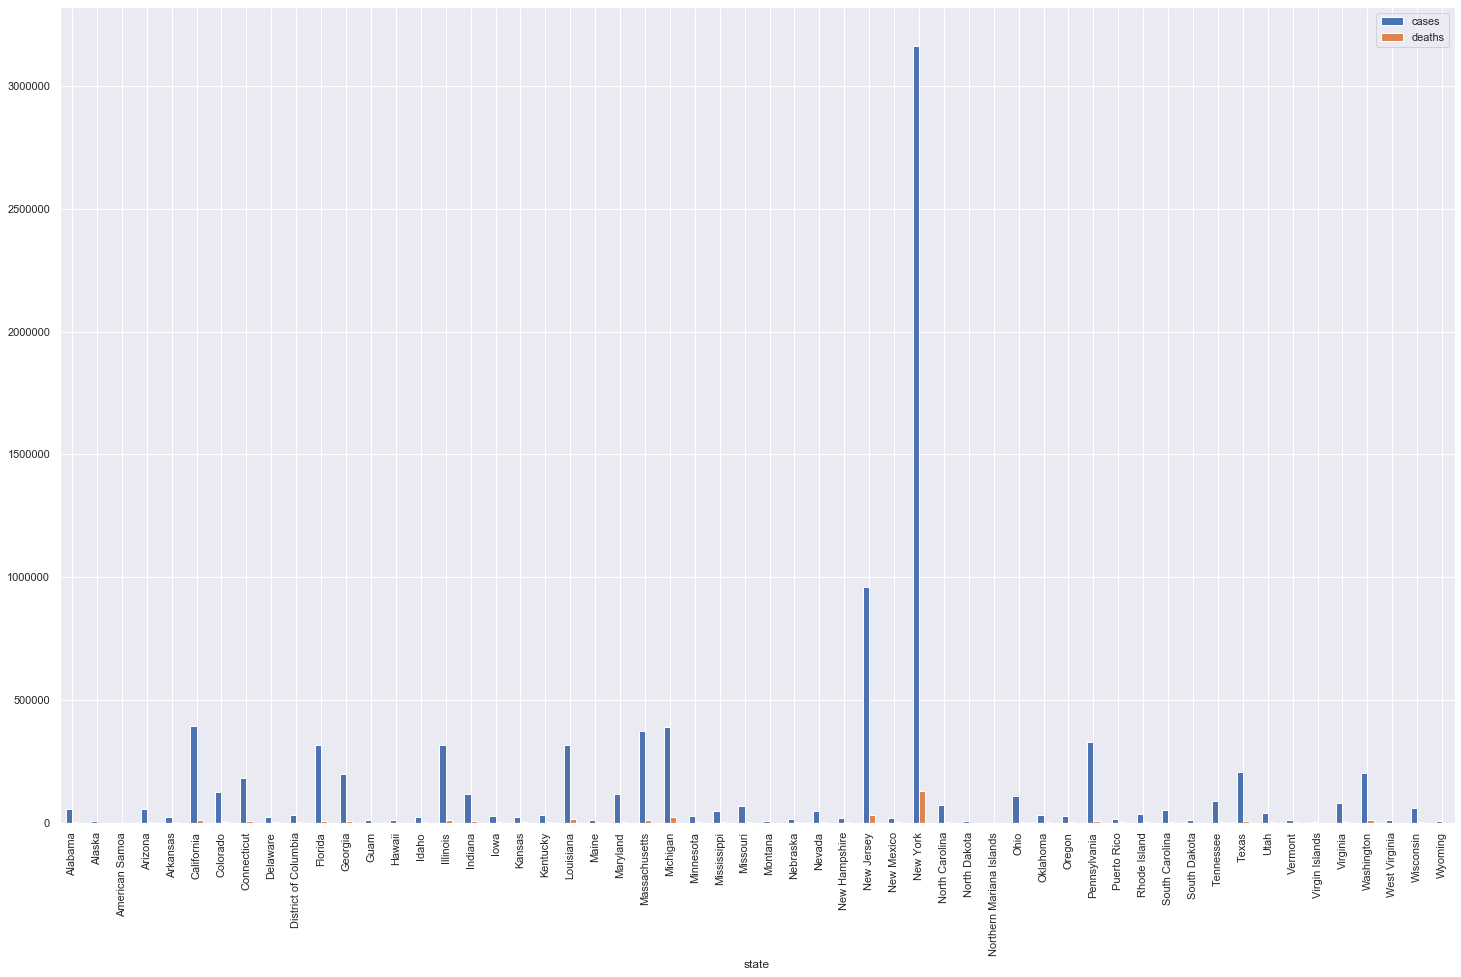

In [159]:
covid_df[['date','state','cases','deaths']].groupby('state').sum().plot(kind='bar', figsize=(25,15))

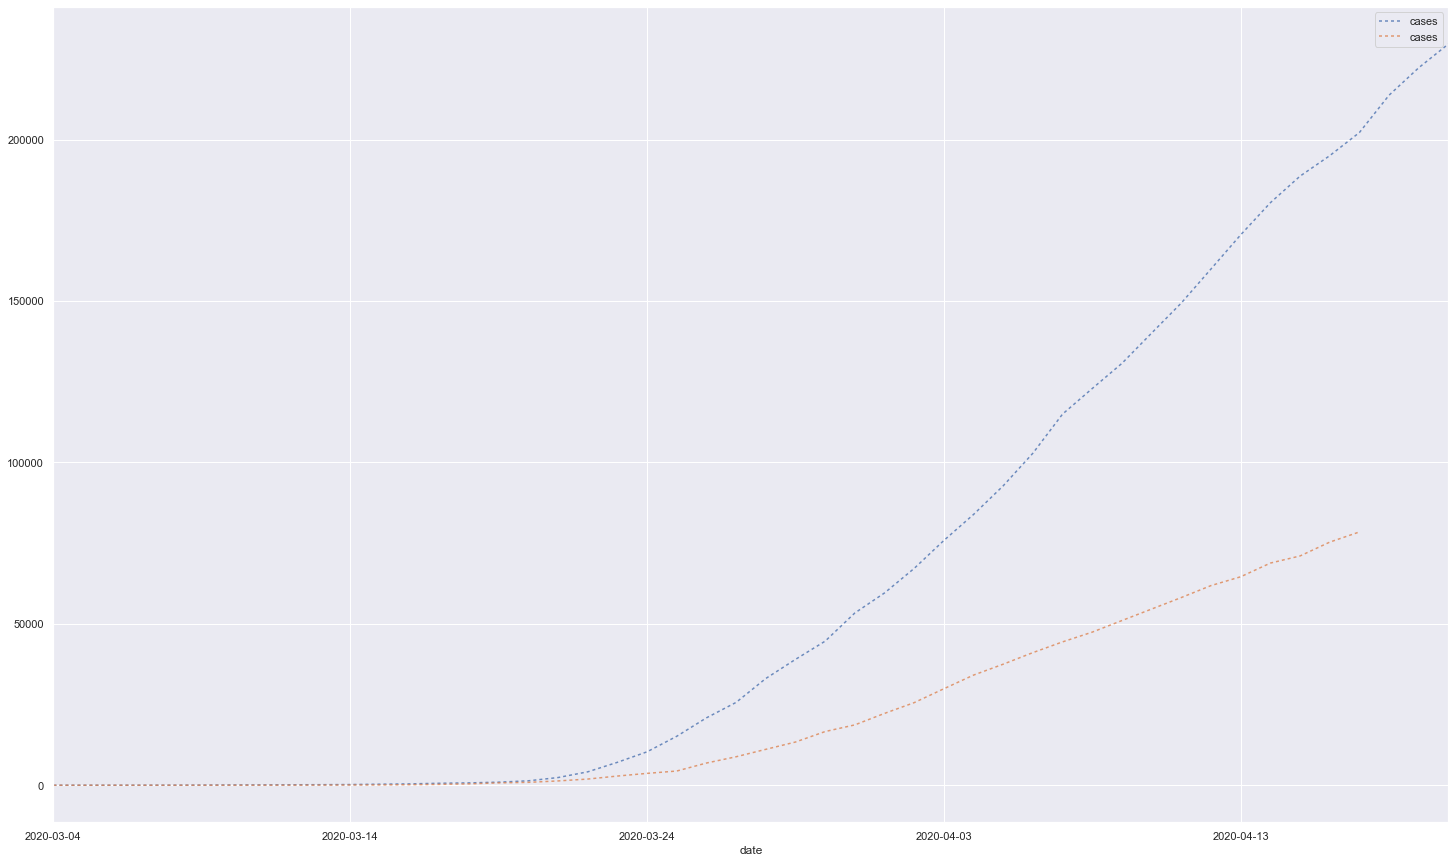

In [160]:
ax=plt.gca()
covid_df[covid_df['state']=='New York'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax, label='New York', grid=True)
covid_df[covid_df['state']=='New Jersey'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax, label='New Jersey', grid=True)
ax1.legend()
plt.show()
#covid_df[covid_df['state']=='Washington'].loc[800:].plot(x='date', figsize=(25,15), kind='line', alpha=0.5, ax=ax1)

In [161]:
NY_df=covid_df[covid_df['state']=='New York'][['state','cases', 'deaths', 'date']]

In [162]:
NY_df.index=NY_df.date

In [163]:
NY_df.drop(columns='date', inplace=True)

In [164]:
NY_df

,state,cases,deaths
date,,,
2020-03-01,New York,1,0
2020-03-02,New York,1,0
2020-03-03,New York,2,0
2020-03-04,New York,11,0
2020-03-05,New York,22,0
2020-03-06,New York,44,0
2020-03-07,New York,89,0
2020-03-08,New York,106,0
2020-03-09,New York,142,0


In [165]:
NY_df.cases.astype('int32', copy=False)

date
2020-03-01         1
2020-03-02         1
2020-03-03         2
2020-03-04        11
2020-03-05        22
2020-03-06        44
2020-03-07        89
2020-03-08       106
2020-03-09       142
2020-03-10       173
2020-03-11       217
2020-03-12       326
2020-03-13       421
2020-03-14       610
2020-03-15       732
2020-03-16       950
2020-03-17      1374
2020-03-18      2382
2020-03-19      4152
2020-03-20      7102
2020-03-21     10356
2020-03-22     15168
2020-03-23     20875
2020-03-24     25665
2020-03-25     33066
2020-03-26     38987
2020-03-27     44635
2020-03-28     53363
2020-03-29     59568
2020-03-30     67174
2020-03-31     75832
2020-04-01     83889
2020-04-02     92770
2020-04-03    102870
2020-04-04    114996
2020-04-05    122911
2020-04-06    130703
2020-04-07    140081
2020-04-08    149401
2020-04-09    159937
2020-04-10    170512
2020-04-11    180458
2020-04-12    188694
2020-04-13    195031
2020-04-14    202208
2020-04-15    213779
2020-04-16    222284
2020-04-

In [166]:
NY_df.index.astype('datetime64[ns]')

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

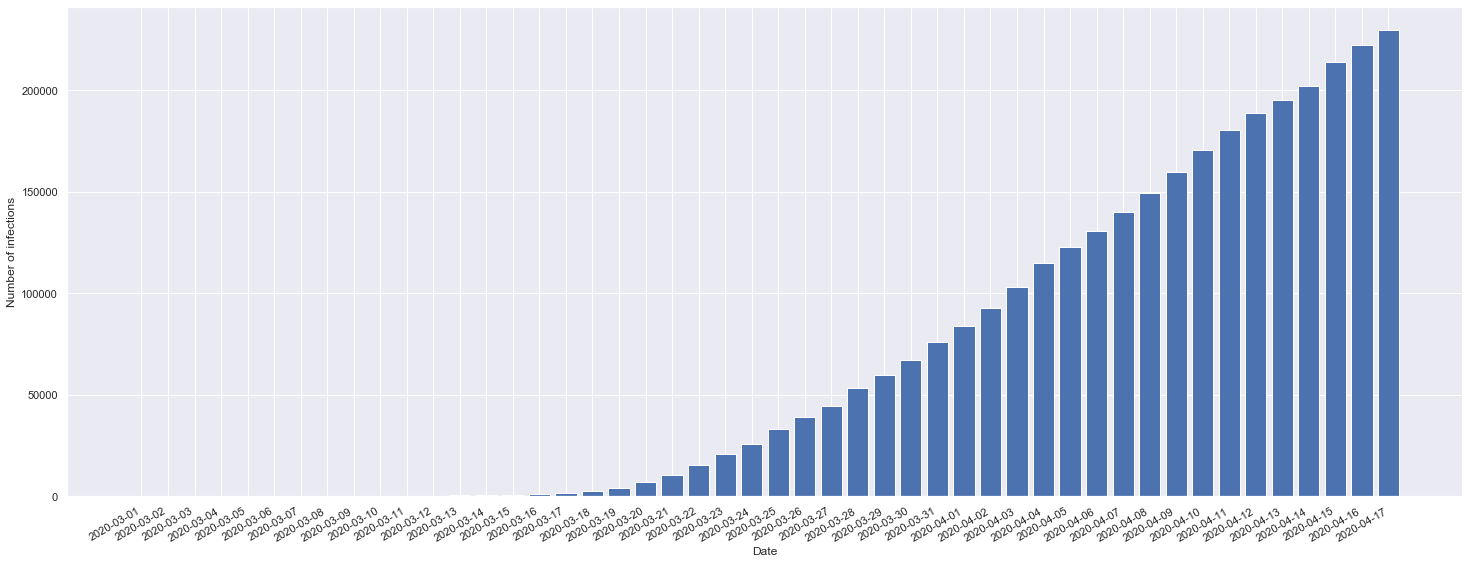

In [167]:
#NY_df.index.to_series().diff().value_counts()
fig, ax=plt.subplots()
ax.bar(NY_df.index, NY_df.cases)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of infections')
plt.show()

In [168]:
NY_rollshort=NY_df.cases.rolling(window=3)
NY_rolllong=NY_df.cases.rolling(window=14)
NY_df['SMA_short']=NY_rollshort.mean()
NY_df['SMA_long']=NY_rolllong.mean()
NY_df['New_cases']=0
NY_df['New_cases_Short_MA']=0
NY_df['New_cases_Long_MA']=0
NY_df['New_deaths']=0
NY_df.fillna(0, inplace=True)



In [169]:
len(NY_df)

48

In [170]:
for i in range(len(NY_df)):
    if NY_df.cases[i]==1:
        i+=1
    else:
        NY_df.New_cases[i]=NY_df.cases[i]-NY_df.cases[i-1]
        NY_df.New_deaths[i]=NY_df.deaths[i]-NY_df.deaths[i-1]
        NY_df.New_cases_Short_MA[i]=NY_df.SMA_short[i]-NY_df.SMA_short[i-1]
        NY_df.New_cases_Long_MA[i]=NY_df.SMA_long[i]-NY_df.SMA_long[i-1]

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyW

In [171]:
NY_df

,state,cases,deaths,SMA_short,SMA_long,New_cases,New_cases_Short_MA,New_cases_Long_MA,New_deaths
date,,,,,,,,,
2020-03-01,New York,1,0,0.000000,0.000000,0,0,0,0
2020-03-02,New York,1,0,0.000000,0.000000,0,0,0,0
2020-03-03,New York,2,0,1.333333,0.000000,1,1,0,0
2020-03-04,New York,11,0,4.666667,0.000000,9,3,0,0
2020-03-05,New York,22,0,11.666667,0.000000,11,6,0,0
2020-03-06,New York,44,0,25.666667,0.000000,22,14,0,0
2020-03-07,New York,89,0,51.666667,0.000000,45,25,0,0
2020-03-08,New York,106,0,79.666667,0.000000,17,28,0,0
2020-03-09,New York,142,0,112.333333,0.000000,36,32,0,0


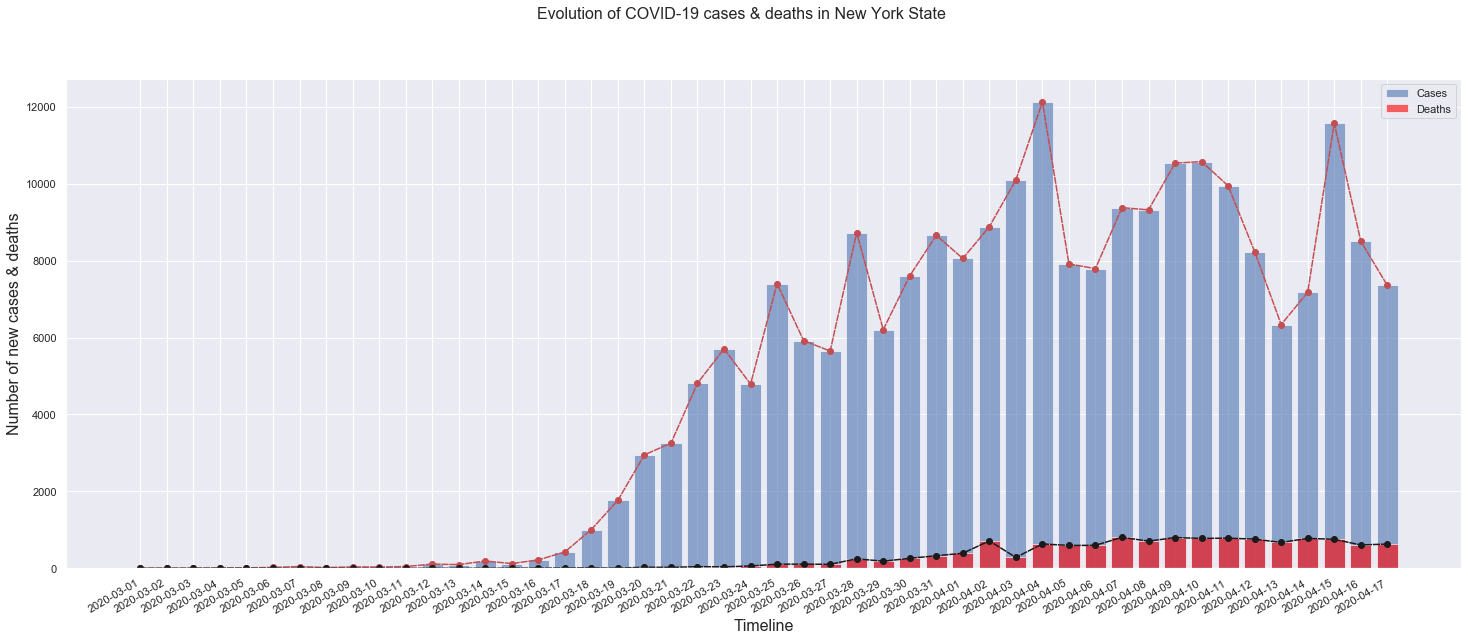

In [175]:
fig, ax=plt.subplots()
ax.bar(NY_df.index, NY_df.New_cases, alpha=0.6, label='Cases')
ax.bar(NY_df.index, NY_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.plot(NY_df.index, NY_df.New_cases, 'ro--', dash_capstyle='projecting' )
ax.plot(NY_df.index, NY_df.New_deaths, 'ko--', dash_capstyle='projecting' )
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
fig.suptitle('Evolution of COVID-19 cases & deaths in New York State', fontsize=16)
plt.savefig('COVID19NYC.pdf', bbox_inches='tight')
plt.show()

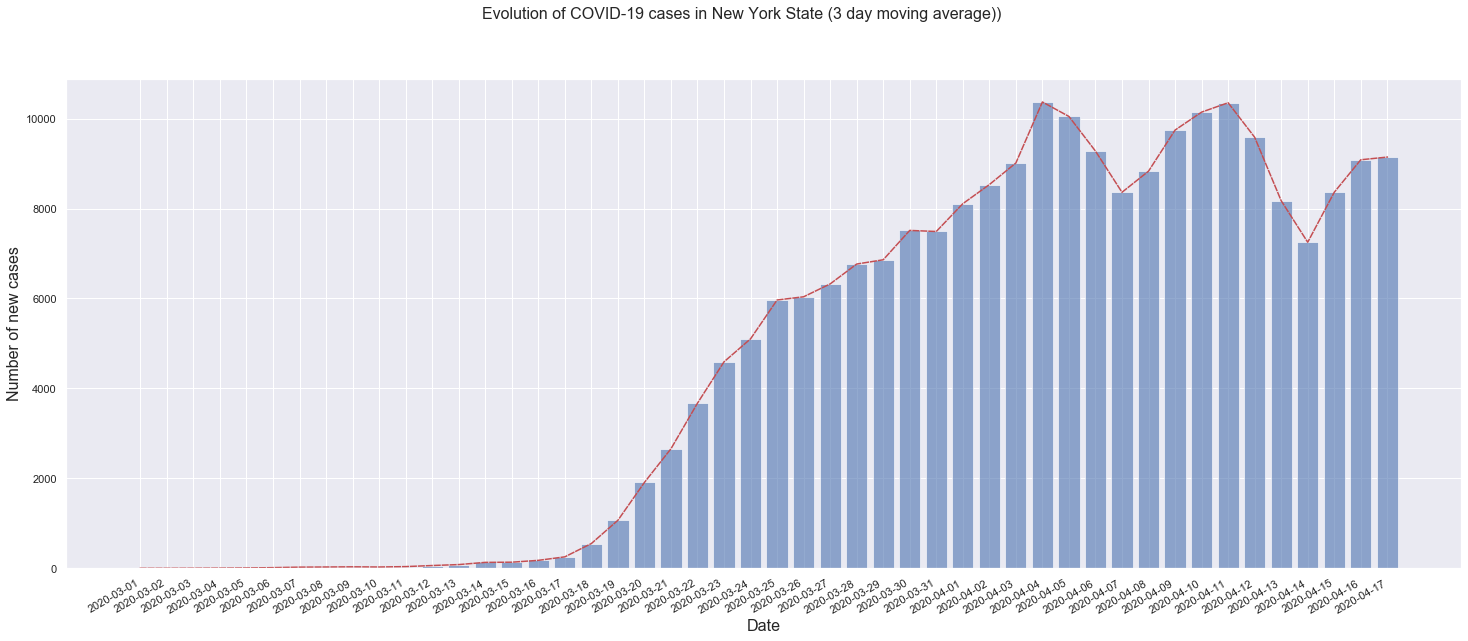

In [173]:
fig, ax=plt.subplots()
ax.bar(NY_df.index, NY_df.New_cases_Short_MA, alpha=0.6)
ax.plot(NY_df.index, NY_df.New_cases_Short_MA, 'r--', dash_capstyle='projecting' )
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of new cases', fontsize=16)
fig.suptitle('Evolution of COVID-19 cases in New York State (3 day moving average))', fontsize=16)
plt.show()

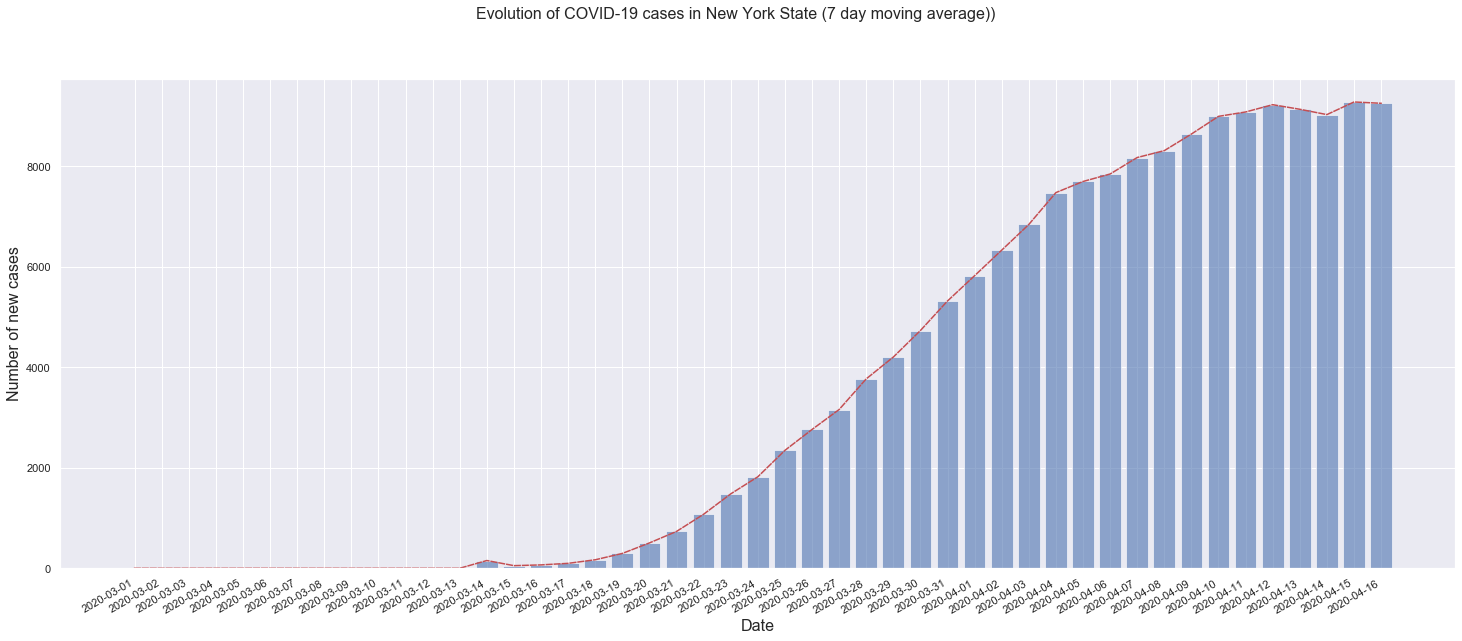

In [119]:
fig, ax=plt.subplots()
ax.bar(NY_df.index, NY_df.New_cases_Long_MA, alpha=0.6)
ax.plot(NY_df.index, NY_df.New_cases_Long_MA, 'r--', dash_capstyle='projecting' )
fig.autofmt_xdate(which='major')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of new cases', fontsize=16)
fig.suptitle('Evolution of COVID-19 cases in New York State (7 day moving average))', fontsize=16)
plt.show()

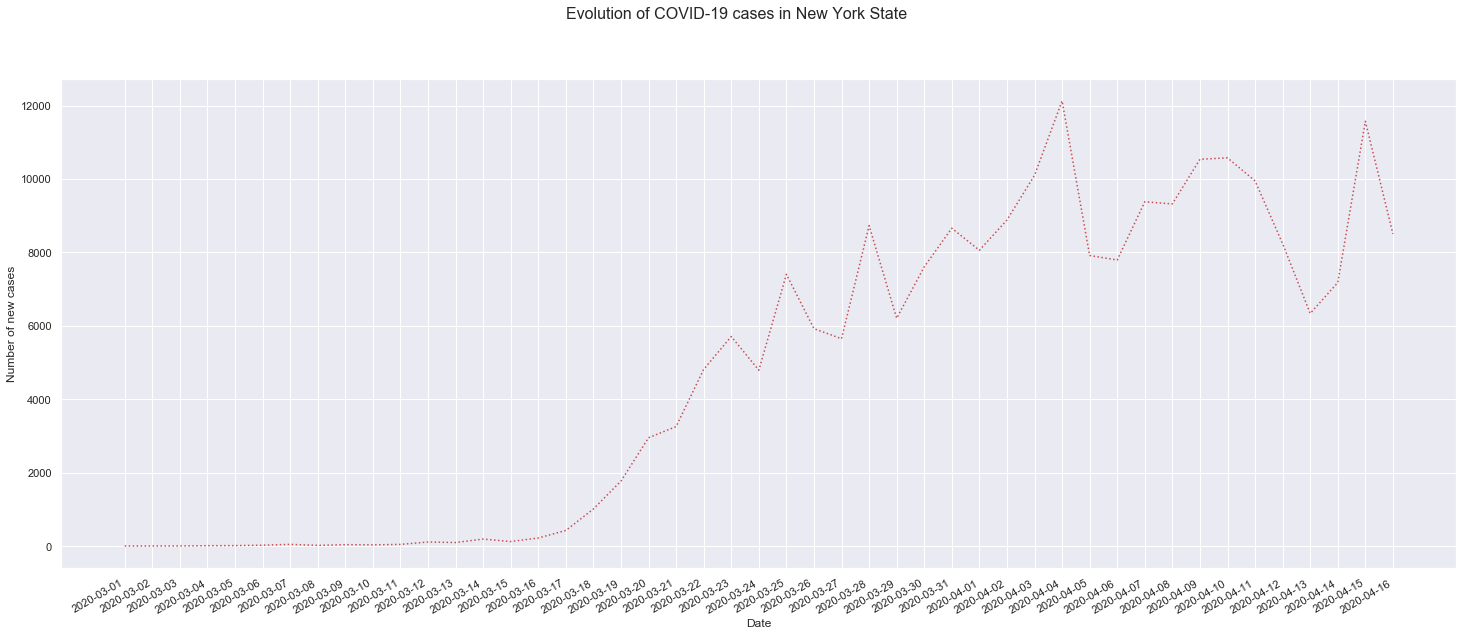

In [104]:
fig, ax=plt.subplots()
ax.plot(NY_df.index, NY_df.New_cases, 'r:')
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of new cases')
fig.suptitle('Evolution of COVID-19 cases in New York State', fontsize=16)
plt.show()

<BarContainer object of 47 artists>

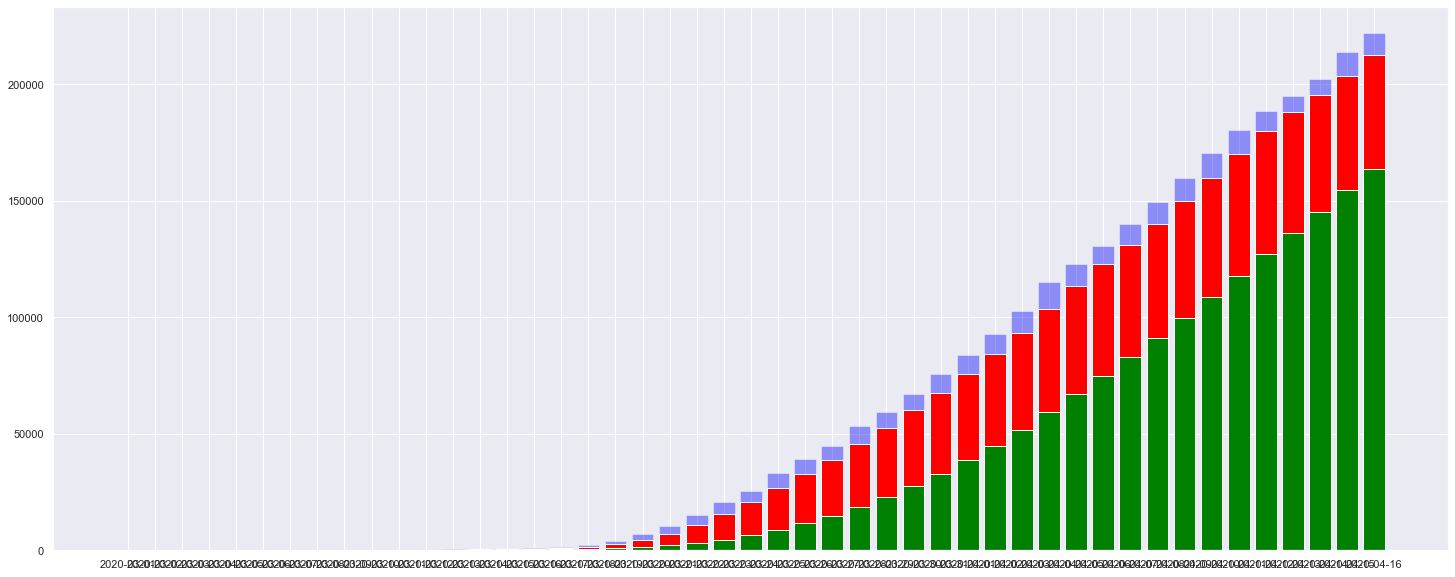

In [105]:
plt.bar(NY_df.index, 
         NY_df.cases, 
         color = 'blue', 
         alpha = 0.4)

plt.bar(NY_df.index, 
         NY_df.SMA_short, 
         color = 'red')

plt.bar(NY_df.index, 
         NY_df.SMA_long, 
         color = 'green')

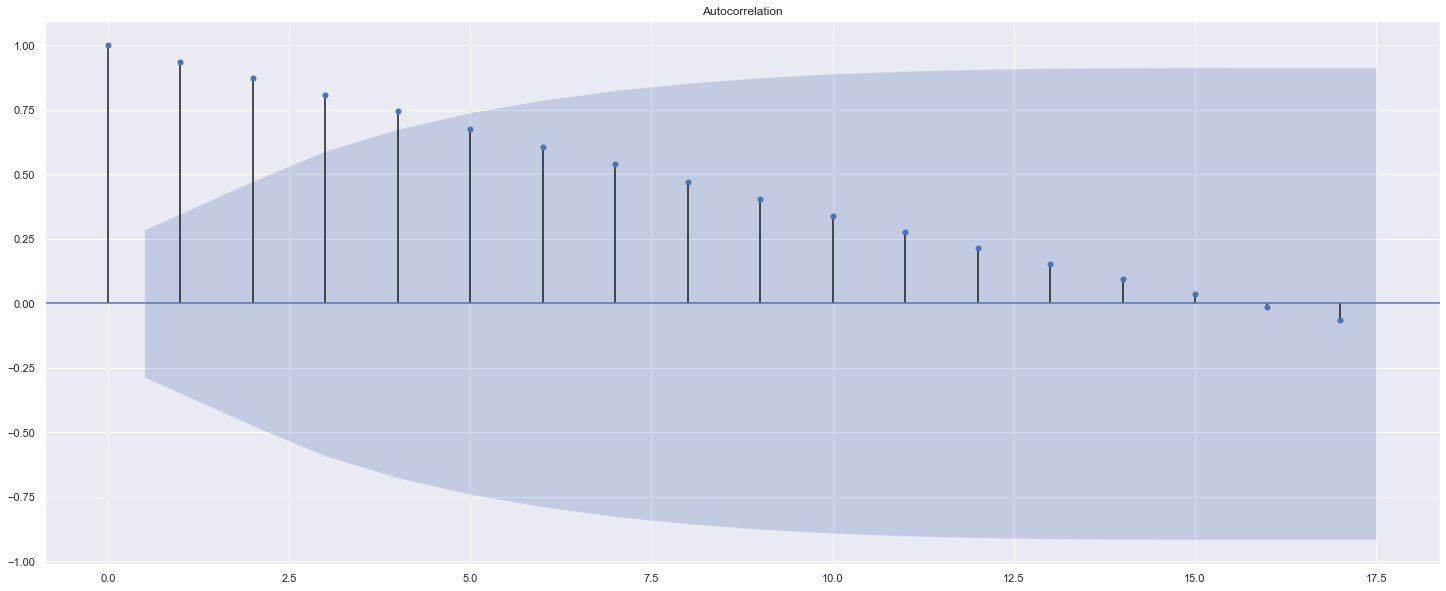

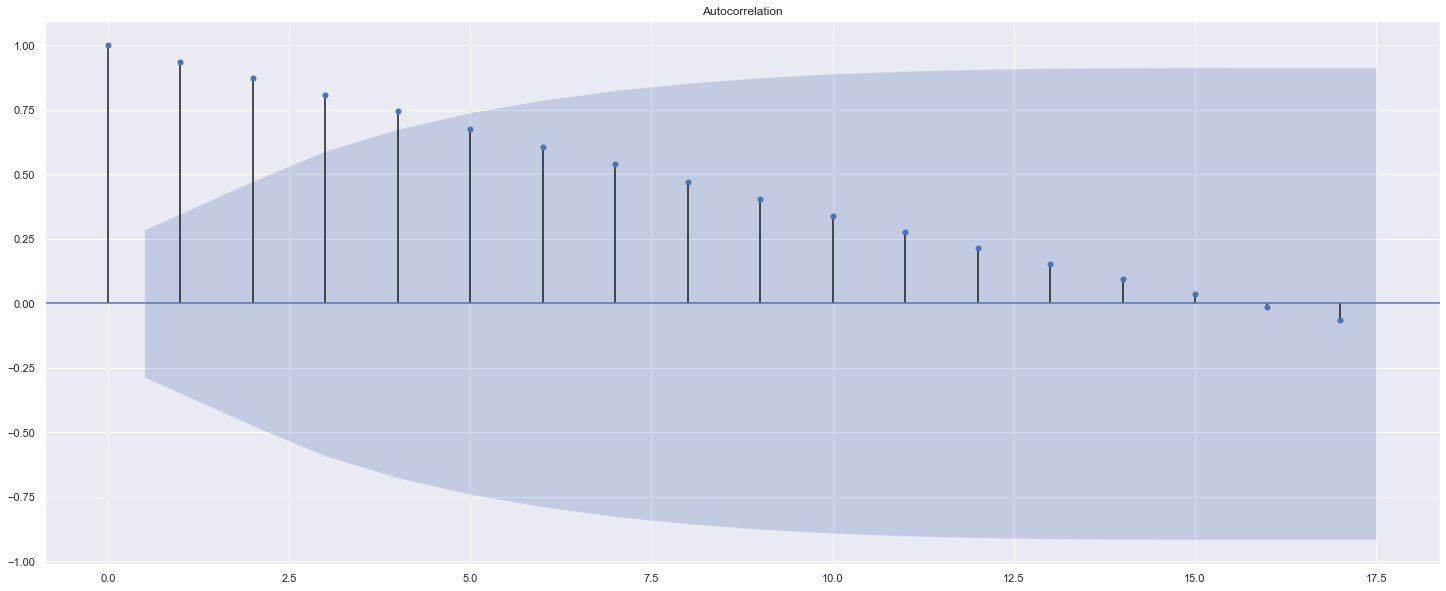

In [106]:
plot_acf(NY_df.cases)

In [107]:
#Total cases & deaths by State sorted descending

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=False)

,cases,deaths
state,,
New York,222284,12192
New Jersey,75317,3518
Massachusetts,32181,1245
Michigan,29119,2091
Pennsylvania,28314,864
California,28142,971
Illinois,25734,1081
Florida,23332,667
Louisiana,22532,1156


In [108]:
choroplet_df=covid_df[['state','cases','deaths']].groupby(by='state', as_index=True).last()
#choroplet_df['State']=choroplet_df['state']


In [109]:
#Total cases in the US

covid_df[['state','cases','deaths']].groupby('state').last().sum()

cases     668532
deaths     30664
dtype: int64

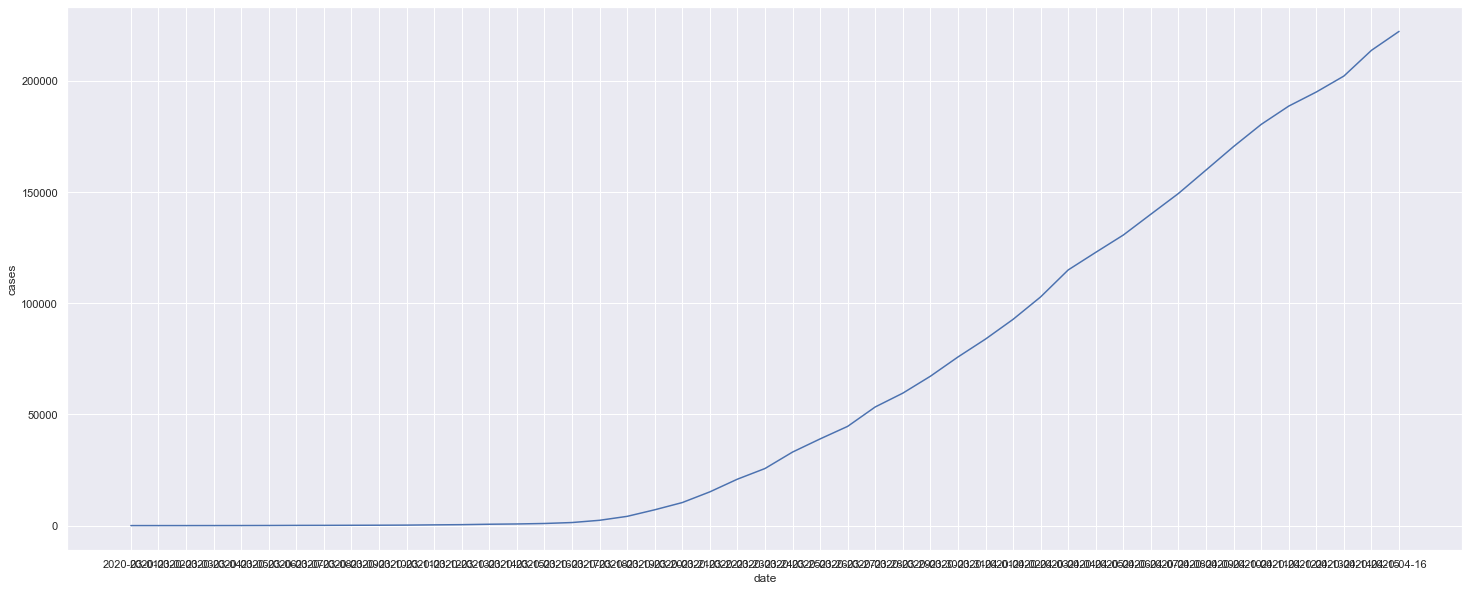

In [110]:
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(data=covid_df[covid_df['state']=='New York'], x='date',y='cases')


In [111]:
m = folium.Map(location=[45.5236, -122.6750])

In [112]:
state_geo

'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

In [113]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
#state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=choroplet_df,
    columns=[choroplet_df.index, 'cases'],
    key_on='feature.properties.name',
    bins=[0,100,1000,5000, 20000, 50000, 100000, 230000],
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of COVID-19 cases'
    
).add_to(m)

folium.LayerControl().add_to(m)

m

In [114]:
MAX_RECORDS = 57
  
# create empty map zoomed in on San Francisco
map = folium.Map(location=[48, -102], zoom_start=3)
 
# add a marker for every record in the filtered data, use a clustered view
for each in choroplet_df[0:MAX_RECORDS].iterrows():
    folium.Marker(
        location = [each[1][choroplet_df.index],each[1][choroplet_df.cases]], 
        clustered_marker = True)
    
display(map)

IndexError: index 4404 is out of bounds for axis 0 with size 2